In [1]:
import datetime
import os
import numpy as np
import scipy.io as sio
import torch
from torch import nn, optim
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0")

In [3]:
def read_data(base_path='./Data',split_size=[0.6, 0.2, 0.2]):  
    """
    Reads all of the .mat files in the given base_path, and returns a dict with the data found there.
    :param BASE_PATH: the path where the INPUT DATA will be read.
    :param SPLIT_SIZE: gives how much of the data goes to the train/test.
    :return: a dict, containing the EES and difference tensors.
    """
    i = 0
    for file in os.listdir(base_path):
        i = i + 1
    pbar = tqdm(total=i)

    data_dict = {}
    for file in os.listdir(base_path):
        num, data_type = file.split('_')
        data_type = data_type.split('.')[0]
        num = int(num)
        if "EES" in data_type:
            tensor_in = sio.loadmat(os.path.join(base_path, file))['EES_value']
            tensor_in = torch.FloatTensor(tensor_in).squeeze(0)
        else:
            tensor_in = sio.loadmat(os.path.join(base_path, file))['Kulonbseg']
            tensor_in = torch.FloatTensor(tensor_in)
        try:
            data_dict[num][data_type] = tensor_in
        except KeyError:
            data_dict[num] = {data_type: tensor_in}
        pbar.update()
    pbar.close()

    new_data = []
    for key in data_dict.keys():
        new_data.append(data_dict[key])
    np.random.shuffle(new_data)
    if isinstance(split_size, list):
        training_samples = int(split_size[0] * len(new_data))
        valid_samples = int(split_size[1] * len(new_data))
        test_samples = int(split_size[2] * len(new_data))
        while sum([training_samples, valid_samples, test_samples]) != len(new_data):
            training_samples += 1
        #split samples
        new_datadict = {'train': new_data[ : training_samples],
                        'validation': new_data[training_samples : training_samples + valid_samples],
                        'test': new_data[-test_samples : ]}
        
    else:
        new_datadict = {'train': new_data,
                        'validation': new_data,
                        'test': new_data}
    print("Adatbetöltés kész")
    return new_datadict

In [4]:
# Load the data and get the splitted dataset
dataset = read_data()

100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Adatbetöltés kész


In [5]:
class Classificator:

    #-------------------------
    # Label   Class
    #-------------------------
    # 0:      Not damaged
    # 1:      Slightly damaged
    # 2:      Damaged
    # 3:      Very damaged
    #-------------------------
    
    def getClassName(self, c):
        if c==0:
            n = "Not Damaged"
        elif c==1:
            n = "Slightly damaged"
        elif c==2:
            n = "Damaged"
        elif c==3:
            n = "Very damaged"
        return n;
    
    def getClass(self, x):
        x = int(x)
        
        if x==0:
            return 0      
        if x<=100/3:
            return 1
        elif  x>100/3 and x<200/3:
            return 2
        else:
            return 3
    
    # Compare Prediction and Label classes
    def isCorrect(self, prediction, label):
        return self.getClass(prediction) == self.getClass(label)

In [6]:
class CarBadnessGuesser(nn.Module):
    def __init__(self, lr=0.01):
        super(CarBadnessGuesser, self).__init__()

        self.valid_freq = 10

        self.model = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=3, kernel_size=(10, 5, 5), stride=(10, 5, 5)),
            nn.BatchNorm3d(3),
            nn.Conv3d(in_channels=3, out_channels=2, kernel_size=5),
            nn.BatchNorm3d(2),
            nn.Conv3d(in_channels=2, out_channels=1, kernel_size=3),
            nn.BatchNorm3d(1),
            nn.AdaptiveMaxPool3d((1, 1, 10)),
        ) 
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=10, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=1),
            nn.ReLU()
        )
        if torch.cuda.is_available():
            self.linear.cuda()
            self.model.cuda()

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(list(self.model.parameters()) + list(self.linear.parameters()), lr=lr)
        
        self.classificator = Classificator()

    def forward(self, x):
        conv_out = self.model(x.unsqueeze(0).unsqueeze(0))
        return self.linear(conv_out.squeeze(-2).squeeze(-2))

    def train(self, epochs=50):
        b_loss = []
        v_loss = []
    
        for epoch in trange(epochs):
            t_correct = 0
            total = 0
            for step, data in enumerate(dataset["train"]):
                input_data = data['KUL'].cuda()
                label = data['EES'].cuda()
                
                prediction = self(input_data)
                loss = self.loss_fn(prediction, label)
                #print('training- ', 'y^', prediction.item(), 'y', label.item(), loss.item())
                
                loss.backward()     
                self.optimizer.step()
                b_loss.append(loss.item())
                
                #check if its prediction matches label class
                if( self.classificator.isCorrect(prediction.item(), label.item()) ):
                    t_correct += 1;
                total += 1;
                
                self.zero_grad()
            if epoch % self.valid_freq and epoch != 0:
                #calculate the training accuracy
                t_acc = t_correct/total * 100
                #print(f'Batch loss: {loss.item()}', flush=True)
             
                vloss, v_acc = self.validation()
                v_loss.append(vloss)
                print(f'Validation loss:', vloss, flush=True)

                
        print('Training acc:', t_acc, '%')
        print('Validation acc: ', v_acc, '%')  
        plt.plot(v_loss)
        plt.ylabel('Validation loss')
        plt.show()
        plt.plot(b_loss)
        plt.ylabel('Batch loss')
        plt.show()

    def validation(self):
        """
        Runs the validation phase of the training
        :return: The validation loss average
        """
        v_correct = 0
        total = 0
        average_loss = 0
        step = 0
        
        for step, data in enumerate(dataset['validation']):
            with torch.no_grad():
                input_data = data['KUL'].cuda()
                label = data['EES'].cuda()
                
                prediction = self(input_data)
                loss = self.loss_fn(prediction, label)               
                #print('validation- ', 'y^', prediction.item(), 'y', label.item(), loss.item())
                #print('v_correct', v_correct, 'total',total)
                
                average_loss += loss.item()
                
                #check if its correct
                c = self.classificator.isCorrect(prediction.item(), label.item())
                if(c == True):
                    v_correct += 1;
                total += 1;
        
        #calculate the validation accuracy
        v_acc = v_correct/total * 100
        return average_loss / (step + 1), v_acc
        print("Validation is complete")
        

    def test(self):
        """
        Runs the evaluation of the network.
        :return: average loss for the test
        """
        t_correct = 0
        total = 0
        average_loss = 0
        step = 0
        
        for step, data in enumerate(dataset['test']):
            with torch.no_grad():
                input_data = data['KUL'].cuda()
                prediction = self(input_data)
                
                loss = self.loss_fn(prediction, data['EES'].cuda())
                
                print('---------------------------------')
                print()
                print('Prediction: ', prediction.item())
                print('Excpected:  ', data['EES'].cuda().item())   
                print()
                prediction_label = self.classificator.getClass(prediction.item())
                print('Class:          ', self.classificator.getClassName(prediction_label))
                expected_label = self.classificator.getClass(data['EES'].cuda())
                print('Expected Class: ', self.classificator.getClassName(expected_label))
                print()
                print('loss: ', loss.item())
                print()
                
                #check if its correct
                c = self.classificator.isCorrect(prediction.item(), data['EES'].cuda().item())
                if(c == True):
                    t_correct += 1;
                total += 1;
                
                average_loss += loss.item()

        #calculate the test accuracy
        t_acc = t_correct/total * 100          
        average_loss = average_loss / step   
        print()
        print('---------------------------------')
        print('Test Accuracy: ', t_acc, ' %')
        print('Average Loss:  ', average_loss)
        print('---------------------------------')
        print()
        print("Test is completed")       
        return average_loss


    def save_weights(self, save_dir="./training"):
        """
        Saves weights to the given directory plus the timestamp
        :return: none
        """
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S.%d")
        save_path = os.path.join(save_dir, timestamp)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # save model within Training folder with timestamp together with preivous models
        torch.save(self.state_dict(), os.path.join(save_path, 'model.weights'))
        # save last model within Weights folder (overwrite)
        torch.save(self.state_dict(), './weights/model.weights')

    def load_weights(self):
        self.load_state_dict = torch.load('./weights/model.weights')
        print("loading weights is complete")


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\igorr\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1/50 [00:03<02:32,  3.10s/it]

Validation loss: 392.040283203125


  4%|▍         | 2/50 [00:04<02:07,  2.66s/it]

Validation loss: 176.81336517333983


  6%|▌         | 3/50 [00:06<01:50,  2.34s/it]

Validation loss: 539.4522216796875


  8%|▊         | 4/50 [00:07<01:38,  2.13s/it]

Validation loss: 72.58234369941056


 10%|█         | 5/50 [00:09<01:28,  1.97s/it]

Validation loss: 403.6458908081055


 12%|█▏        | 6/50 [00:11<01:22,  1.87s/it]

Validation loss: 120.99157648086548


 14%|█▍        | 7/50 [00:12<01:17,  1.80s/it]

Validation loss: 239.06736907958984


 16%|█▌        | 8/50 [00:14<01:13,  1.74s/it]

Validation loss: 189.0157554626465


 18%|█▊        | 9/50 [00:16<01:09,  1.70s/it]

Validation loss: 148.3483093261719


 22%|██▏       | 11/50 [00:19<01:01,  1.58s/it]

Validation loss: 148.8328125


 24%|██▍       | 12/50 [00:20<01:00,  1.59s/it]

Validation loss: 161.7393768310547


 26%|██▌       | 13/50 [00:22<00:59,  1.61s/it]

Validation loss: 194.35913848876953


 28%|██▊       | 14/50 [00:23<00:57,  1.60s/it]

Validation loss: 216.89400329589844


 30%|███       | 15/50 [00:25<00:56,  1.62s/it]

Validation loss: 180.130912399292


 32%|███▏      | 16/50 [00:27<00:55,  1.62s/it]

Validation loss: 183.4118282318115


 34%|███▍      | 17/50 [00:28<00:53,  1.63s/it]

Validation loss: 171.92673435211182


 36%|███▌      | 18/50 [00:30<00:51,  1.62s/it]

Validation loss: 152.66454458236694


 38%|███▊      | 19/50 [00:32<00:50,  1.63s/it]

Validation loss: 145.87978053092957


 42%|████▏     | 21/50 [00:35<00:45,  1.56s/it]

Validation loss: 95.80326261520386


 44%|████▍     | 22/50 [00:36<00:44,  1.59s/it]

Validation loss: 97.41121081709862


 46%|████▌     | 23/50 [00:38<00:43,  1.60s/it]

Validation loss: 97.0985320687294


 48%|████▊     | 24/50 [00:39<00:41,  1.60s/it]

Validation loss: 104.0643140077591


 50%|█████     | 25/50 [00:41<00:40,  1.60s/it]

Validation loss: 107.49956645965577


 52%|█████▏    | 26/50 [00:43<00:38,  1.62s/it]

Validation loss: 82.67639440894126


 54%|█████▍    | 27/50 [00:44<00:37,  1.65s/it]

Validation loss: 91.80191515386105


 56%|█████▌    | 28/50 [00:46<00:37,  1.70s/it]

Validation loss: 103.56955305337905


 58%|█████▊    | 29/50 [00:48<00:36,  1.73s/it]

Validation loss: 107.55109955668449


 62%|██████▏   | 31/50 [00:51<00:30,  1.61s/it]

Validation loss: 84.37759860940278


 64%|██████▍   | 32/50 [00:53<00:28,  1.60s/it]

Validation loss: 67.18999955691397


 66%|██████▌   | 33/50 [00:54<00:27,  1.62s/it]

Validation loss: 43.92383677512407


 68%|██████▊   | 34/50 [00:56<00:25,  1.62s/it]

Validation loss: 38.412485076859596


 70%|███████   | 35/50 [00:58<00:24,  1.62s/it]

Validation loss: 31.735175914689897


 72%|███████▏  | 36/50 [00:59<00:22,  1.62s/it]

Validation loss: 27.395668113604188


 74%|███████▍  | 37/50 [01:01<00:20,  1.61s/it]

Validation loss: 28.974106900393963


 76%|███████▌  | 38/50 [01:02<00:19,  1.62s/it]

Validation loss: 28.644451935589313


 78%|███████▊  | 39/50 [01:04<00:17,  1.62s/it]

Validation loss: 30.938490287587047


 82%|████████▏ | 41/50 [01:07<00:14,  1.56s/it]

Validation loss: 33.049077744036914


 84%|████████▍ | 42/50 [01:09<00:12,  1.61s/it]

Validation loss: 33.725314766913655


 86%|████████▌ | 43/50 [01:11<00:11,  1.63s/it]

Validation loss: 34.3414049513638


 88%|████████▊ | 44/50 [01:12<00:09,  1.65s/it]

Validation loss: 34.636261738464235


 90%|█████████ | 45/50 [01:14<00:08,  1.67s/it]

Validation loss: 35.65077078081667


 92%|█████████▏| 46/50 [01:16<00:06,  1.70s/it]

Validation loss: 35.197235624864696


 94%|█████████▍| 47/50 [01:17<00:05,  1.69s/it]

Validation loss: 35.57630108594894


 96%|█████████▌| 48/50 [01:19<00:03,  1.71s/it]

Validation loss: 36.302091306447984


 98%|█████████▊| 49/50 [01:21<00:01,  1.70s/it]

Validation loss: 36.49488668143749


100%|██████████| 50/50 [01:23<00:00,  1.66s/it]


Training acc: 93.33333333333333 %
Validation acc:  100.0 %


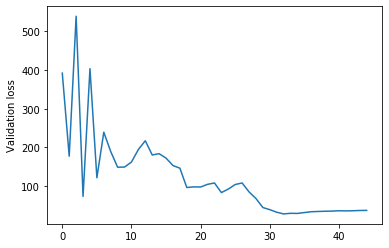

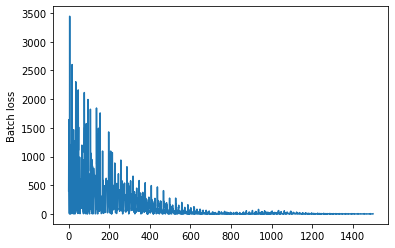

loading weights is complete
---------------------------------

Prediction:  15.87420654296875
Excpected:   7.726019859313965

Class:           Slightly damaged
Expected Class:  Slightly damaged

loss:  66.3929443359375

---------------------------------

Prediction:  25.991798400878906
Excpected:   20.254056930541992

Class:           Slightly damaged
Expected Class:  Slightly damaged

loss:  32.92167663574219

---------------------------------

Prediction:  0.5163233280181885
Excpected:   0.02112000063061714

Class:           Not Damaged
Expected Class:  Not Damaged

loss:  0.24522632360458374

---------------------------------

Prediction:  30.475635528564453
Excpected:   36.852481842041016

Class:           Slightly damaged
Expected Class:  Damaged

loss:  40.66416931152344

---------------------------------

Prediction:  0.5163233280181885
Excpected:   0.5008800029754639

Class:           Not Damaged
Expected Class:  Not Damaged

loss:  0.00023849628632888198

---------------------

In [7]:
if __name__ == "__main__":
    
    # set mode
    TRAIN = True
    TEST = True
    
    # instanciate the NN
    net = CarBadnessGuesser()
    torch.backends.cudnn.enabled = False

    # Train, Validate and Save the model
    if(TRAIN):
        net.train()
        net.save_weights()
    
    # Load the model and Test
    if(TEST):
        net.load_weights()
        net.test()
    